In [1]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from matplotlib.dates import datestr2num
import torch.optim as optim
from sklearn import preprocessing
import math
from scipy.stats import gaussian_kde
from datetime import datetime
import random

class ChaniaDataset(Dataset):
    def __init__(self, csv_file, num_features, transform=None, normalize=True, seq_len=5, sample_f=12):
        self.num_features = num_features
        self.seq_len = seq_len
        self.sample_f = sample_f
        Data = pd.read_csv(csv_file, header=0, usecols = [0]+list(range(2,26)), converters={0:lambda x: datestr2num(x)})
        Id = pd.read_csv(csv_file, header=0, usecols=["iPhoneUID"],converters={"iPhoneUID": lambda x: userID[x]})
        self.augmented_data = []
        self.userlabels = []
        
        self.DataByUser = {}
        self.DataByUserS = {}
        # Store the data with timestamp by user id
        for userid in range(6):
            datalist = [Data.iloc[x].values.astype('float').reshape(-1,self.num_features) 
                                             for x in np.where(Id.iloc[:].values.astype("int").reshape(-1)==userid)[0]]
            if datalist!=[]:
                self.DataByUser[userid] = np.concatenate(datalist, axis=0)
                self.DataByUser[userid][:,0] = np.round(self.DataByUser[userid][:,0] * 100000 
                                                     - self.DataByUser[0][0,0] * 100000) % 86400
                # Smooth the time sequence with interval 6s X sample_f 
                flag = 0
                tmp = []
                while flag < len(self.DataByUser[userid][:,0]) - sample_f - 1:
                    if (self.DataByUser[userid][flag + sample_f,0] - self.DataByUser[userid][flag,0]) < 9 * sample_f \
                    and (self.DataByUser[userid][flag + sample_f,0] - self.DataByUser[userid][flag,0]) > 5 * sample_f:
                        tmp.append(np.mean(self.DataByUser[userid][flag:flag + sample_f,:],axis=0).reshape(-1,num_features))
                    flag = flag + sample_f
                if tmp != []:
                    self.DataByUserS[userid] = np.concatenate(tmp, axis=0)
                    # Sample sequence data
                    flag = 0
                    for idx in range(len(self.DataByUserS[userid])-seq_len):
                        if flag < 2000 \
                        and (self.DataByUserS[userid][idx + seq_len,0] - self.DataByUserS[userid][idx,0]) < 9 * sample_f * seq_len \
                        and (self.DataByUserS[userid][idx + seq_len,0] - self.DataByUserS[userid][idx,0]) > 5 * sample_f * seq_len:
                            self.augmented_data.append(self.DataByUserS[userid][idx:idx + seq_len,:].reshape(-1,num_features))
                            self.userlabels.append(np.array([userid]).reshape(-1,1))
                            flag += 1
        print(np.shape(self.augmented_data))
        self.augmented_data = np.stack(self.augmented_data, axis=0)
        self.userlabels = np.stack(self.userlabels, axis=0)
        self.transform = transform

        if normalize:
            self.augmented_data=(self.augmented_data-self.augmented_data.mean(axis=0))/self.augmented_data.std(axis=0)

    def __len__(self):
        return len(self.augmented_data)

    def __getitem__(self, idx):
        if type(idx) == torch.Tensor:
            idx = idx.item()
        data = self.augmented_data[idx]
        user = self.userlabels[idx]
        sample = {'x':data, 'u':user}
        if self.transform:
            sample = self.transform(sample)
        return sample
    
class ToTensor(object):
    def __call__(self, sample):
        data, user = sample['x'], sample['u']
        return {'x':torch.from_numpy(data), 'u':torch.from_numpy(user)}
 

In [2]:
FILENAME = './Dataset/augmented_data.csv'
NUM_FEATURES = 25
userID = {
'a841f74e620f74ec443b7a25d7569545':0,
'22223276ea84bbce3a62073c164391fd':1,
'7cbc37da05801d46e7d80c3b99fd5adb':2,
'6882f6cf8c72d6324ba7e6bb42c9c7c2':3,
'1e33db5d2be36268b944359fbdbdad21':4,
'892d2c3aae6e51f23bf8666c2314b52f':5,
'510635002cb29804d54bff664cab52be':6,
'7023889b4439d2c02977ba152d6f4c6e':7,
'8425a81da55ec16b7f9f80c139c235a2':8,
}

In [3]:
chania_dataset = ChaniaDataset(csv_file=FILENAME, num_features=NUM_FEATURES, transform=ToTensor(), normalize=True)
print(np.shape(chania_dataset.augmented_data))
print(np.shape(chania_dataset.userlabels))

(12000, 5, 25)
(12000, 5, 25)
(12000, 1, 1)


/Users/usczj/.conda/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide


(2110, 25)


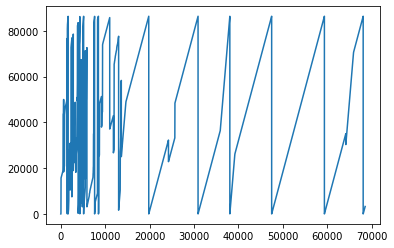

In [4]:
import matplotlib.pyplot as plt
plt.plot(chania_dataset.DataByUser[0][:,0])
# 0,1,3,6,7,8
index = 5
print(np.shape(chania_dataset.DataByUserS[index]))
# print(np.sum(chania_dataset.DataByUser[index][600:,0]-chania_dataset.DataByUser[index][:-600,0] < 10*600))
# print(np.sum(chania_dataset.DataByUser[index][1:,0]-chania_dataset.DataByUser[index][:-1,0] < 10))
# print(np.sum(chania_dataset.DataByUser[index][1:,0]-chania_dataset.DataByUser[index][:-1,0] > 5))

In [5]:
import scipy.io as sio
sio.savemat("Data_L_5.mat",{"data":chania_dataset.augmented_data,"label":chania_dataset.userlabels})